# Assignment #4 FRED Data Analysis

### Objective:

1. Download and plot 3 apparently related sets of data with at least. Each set should contain at least two related variables. You should explain how variables in each set of data are related. Plot each set using the scatter plot function and the line graph function.

2. Create a correlation matrix plot for quarterly observations of Nominal GDP, Real GDP, the Price Level (CPI or GDP Deflator), the quantity of currency in circulation for as large of a date range as possible. Then, calculate the year-over-year percent change for each each variable and save the results as variables in the same dataframe. Create a correlation matrix for these new variables.

3. Download data for 1 Year, 2 Year, 5 Year, 10 Year, and 30 Year U.S. Treasuries (Constant Maturity Rates). Create a function that creates a yield for each date.

4. Plot all of the variables from (3) in a single time series line plot. Indicate using shaded regions any period where the 5 Year rate is less than the 1 year rate. Save this plot in the same pdf that you used in (3).

In [1]:
#plots.py
import os
import pandas
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import datetime
import math

def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

def plot_ts_scatter(df, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    plot_vars = list(df.keys())
    for var1 in plot_vars:
        for var2 in plot_vars:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(plot_vars).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_lines(df, title = False, linewidth = 1, figsize = (40,20), full_index = False, 
               h_line = False, max_y = False, legend = True, pp = None, show_inversion = False):
    fig, ax = plt.subplots(figsize = figsize)
    # If no secondary_y (axis), plot all variables at once
    df.plot.line(linewidth = linewidth, ax = ax, legend = legend)
    if h_line != False:
        ax.axhline(h_line, ls = "--", linewidth = 1.5, color = "k")
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    if max_y != False:
        ax.set_ylim(bottom = 0, top = max_y)
    if full_index:
        plt.xticks([i for i in range(len(df.index))], list(df.index))
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 

    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 
    if title != False:
        plt.title(title, fontsize = 72)

    if show_inversion:
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(df.index, 0, df.max().max(), where=df["2 Y (%)"] < df["1 M (%)"],
                    facecolor='red', alpha=0.2, transform = trans)
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")
    plt.savefig(filename[:50] + " line.png",
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_stacked_lines(df, plot_vars, linewidth = 1, figsize = (40,20), 
                       pp = None, total_var = False):
    fig, ax = plt.subplots(figsize = figsize)
#    mpl_colors = ["C" + str(i) for i in range(11)]
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax, c = "k",
              label = total_var, ls = "--")
    ax.legend(loc=2, ncol = 2)

In [15]:
data_codes  = {"IOER (%)":"IOER",
              "EFFR (%)": "DFF",
              "1 M (%)": "DGS1MO",
              "3 M (%)": "DGS3MO",
              "6 M (%)": "DGS6MO",               
              "1 Y (%)": "DGS1",
              "2 Y (%)": "DGS2",
              "3 Y (%)": "DGS3",
              "5 Y (%)": "DGS5",
              "7 Y (%)": "DGS7",
              "10 Y (%)": "DGS10",
              "20 Y (%)": "DGS20",
              "30 Y (%)": "DGS30",
              "Expected Inflation (%)":"T10YIE",
              "Inflation (%)": "CPIAUCSL",
              "Unemployment Rate (%)": "UNRATE",
              "Initial Claims (N)": "ICSA",
              "All Employees, Total Nonfarm (N)": "PAYEMS",
              "Nominal GDP": "GDP",
              "Real GDP": "GNP",
              "Consumer Price Index": "CPIAUCSL"}
                  
# Select start and end dates
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "M").dropna()
#data["30 Y - 1 M"] = data["30 Y (%)"].add(-1 * data["1 M (%)"])
data["Inflation (%)"] = data["Inflation (%)"].pct_change(12)*100

In [16]:
# Display Data we have pulled in a table
data.dropna()

,IOER (%),EFFR (%),1 M (%),3 M (%),6 M (%),1 Y (%),2 Y (%),3 Y (%),5 Y (%),7 Y (%),...,20 Y (%),30 Y (%),Expected Inflation (%),Inflation (%),Unemployment Rate (%),Initial Claims (N),"All Employees, Total Nonfarm (N)",Nominal GDP,Real GDP,Consumer Price Index
DATE,,,,,,,,,,,,,,,,,,,,,
2011-10-31,0.250000,0.070645,0.013500,0.019000,0.054500,0.114500,0.280500,0.471000,1.061500,1.619000,...,2.869500,3.128000,1.966000,4.495495,8.8,402400,132562.0,15796.460,16059.096,226.750
2012-01-31,0.250000,0.081935,0.024500,0.034500,0.065500,0.115000,0.240500,0.358000,0.835000,1.380500,...,2.695000,3.026000,2.074500,7.506618,8.3,377750,133250.0,16019.758,16268.022,227.842
2012-04-30,0.250000,0.139333,0.066667,0.083810,0.139048,0.183333,0.291905,0.431905,0.894762,1.425238,...,2.816667,3.184286,2.266667,7.746734,8.2,381750,133834.0,16152.257,16380.378,229.187
2012-07-31,0.250000,0.156452,0.069524,0.097143,0.145714,0.185714,0.248095,0.330952,0.619524,0.984286,...,2.217143,2.590000,2.128571,6.456601,8.2,372500,134159.0,16257.151,16485.807,228.590
2012-10-31,0.250000,0.158387,0.109524,0.104762,0.149048,0.179524,0.277143,0.369048,0.708571,1.145714,...,2.505714,2.900476,2.494762,6.987700,7.8,368500,134677.0,16358.863,16583.025,231.638
2013-01-31,0.250000,0.142581,0.051905,0.074286,0.107619,0.145238,0.265238,0.390476,0.805238,1.298571,...,2.681429,3.080476,2.523333,6.524958,8.0,353000,135263.0,16569.591,16783.690,231.679
2013-04-30,0.250000,0.145000,0.049091,0.060000,0.094091,0.124545,0.232273,0.340455,0.710455,1.152273,...,2.550000,2.932727,2.411364,6.620884,7.6,347250,135871.0,16637.926,16866.179,231.797
2013-07-31,0.250000,0.092581,0.020909,0.035455,0.073636,0.121818,0.340909,0.644091,1.403182,1.991364,...,3.307273,3.605000,2.122273,7.028791,7.3,346000,136386.0,16848.748,17090.464,232.900
2013-10-31,0.250000,0.087097,0.105909,0.047273,0.075909,0.121364,0.335455,0.627727,1.366818,1.993636,...,3.379545,3.675909,2.187273,6.681124,7.2,358500,137040.0,17083.137,17321.999,233.669


### Question #1 

The 3 data sets I pulled were. 
    1. Unemployment Rate (is the number of unemployed as a percentage of the labor force)
    2. Initial Claims (is a claim filed by an unemployed individual after a separation from an employer)
    3. All Employees (represent the number of jobs added or lost in an economy)

How are they Related?

Unemployment and intial claims data are positively correlated with each other. As one goes up so will the other. Then both are less correlated to all employees data. Generally, the U.S. labor force and levels of unemployment and employment are subject to fluctuations due to seasonal changes in weather, major holidays, and the opening and closing of schools.  

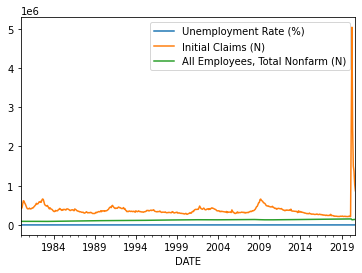

In [57]:
# Creating line graphs
# Pulling the data from library
from datlib.plots import * 
from datlib.FRED import *
# data I am pulling from library
data_codes  = {"Unemployment Rate (%)": "UNRATE", 
               "Initial Claims (N)": "ICSA",
              "All Employees, Total Nonfarm (N)": "PAYEMS"}
# Select start and end dates
start = datetime.datetime(1980, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "M")

start = datetime.datetime(1980, 1, 1)
end = datetime.datetime.today()
data = gather_data(data_codes = data_codes, 
                   start = start,
                  end = end,
                  freq = "M")
plt.rcParams.update({"font.size":10})
data.plot.line()

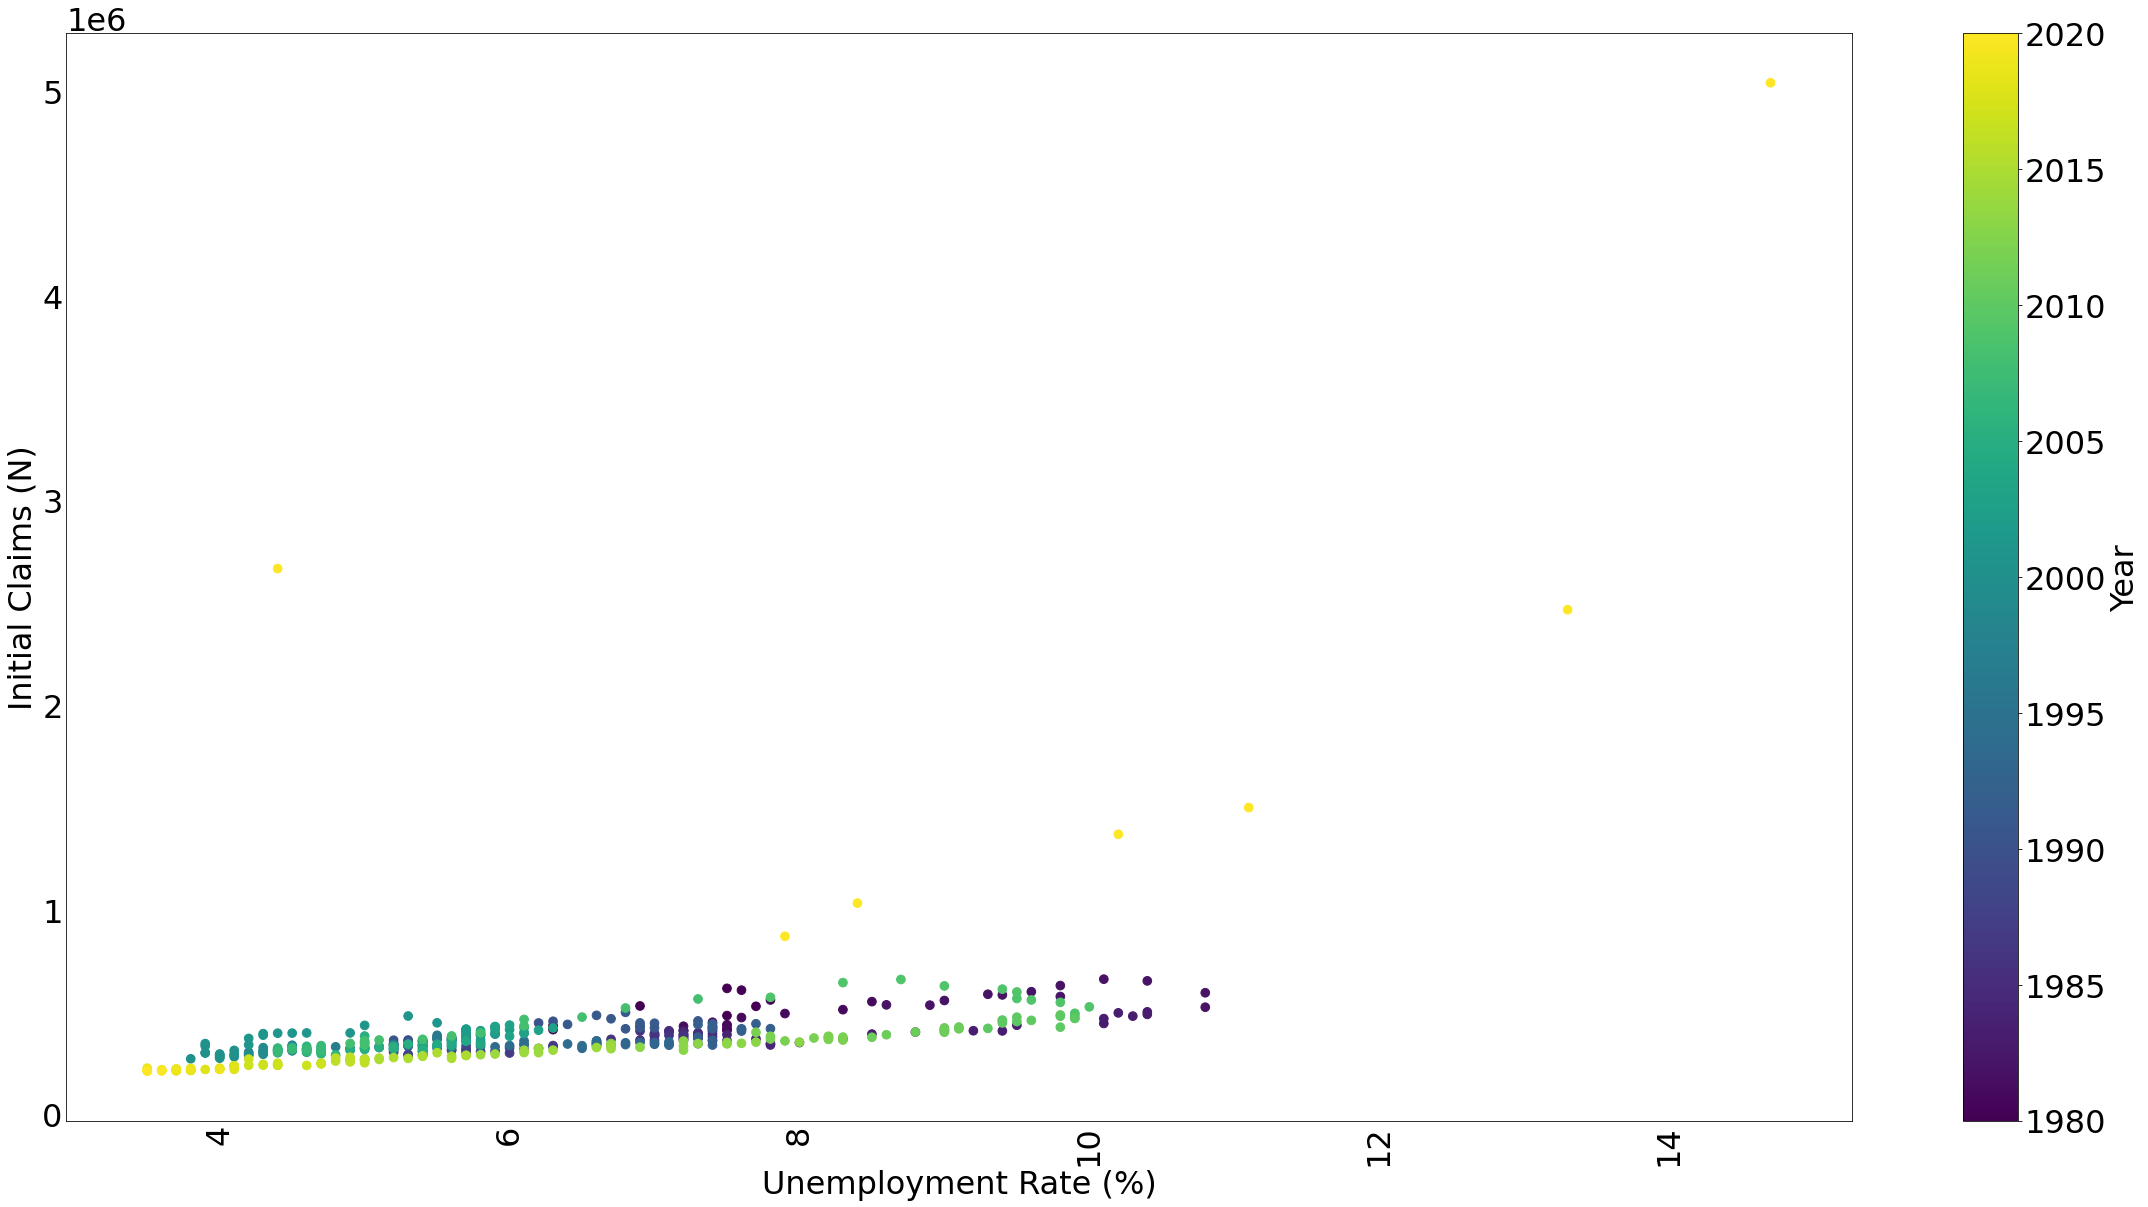

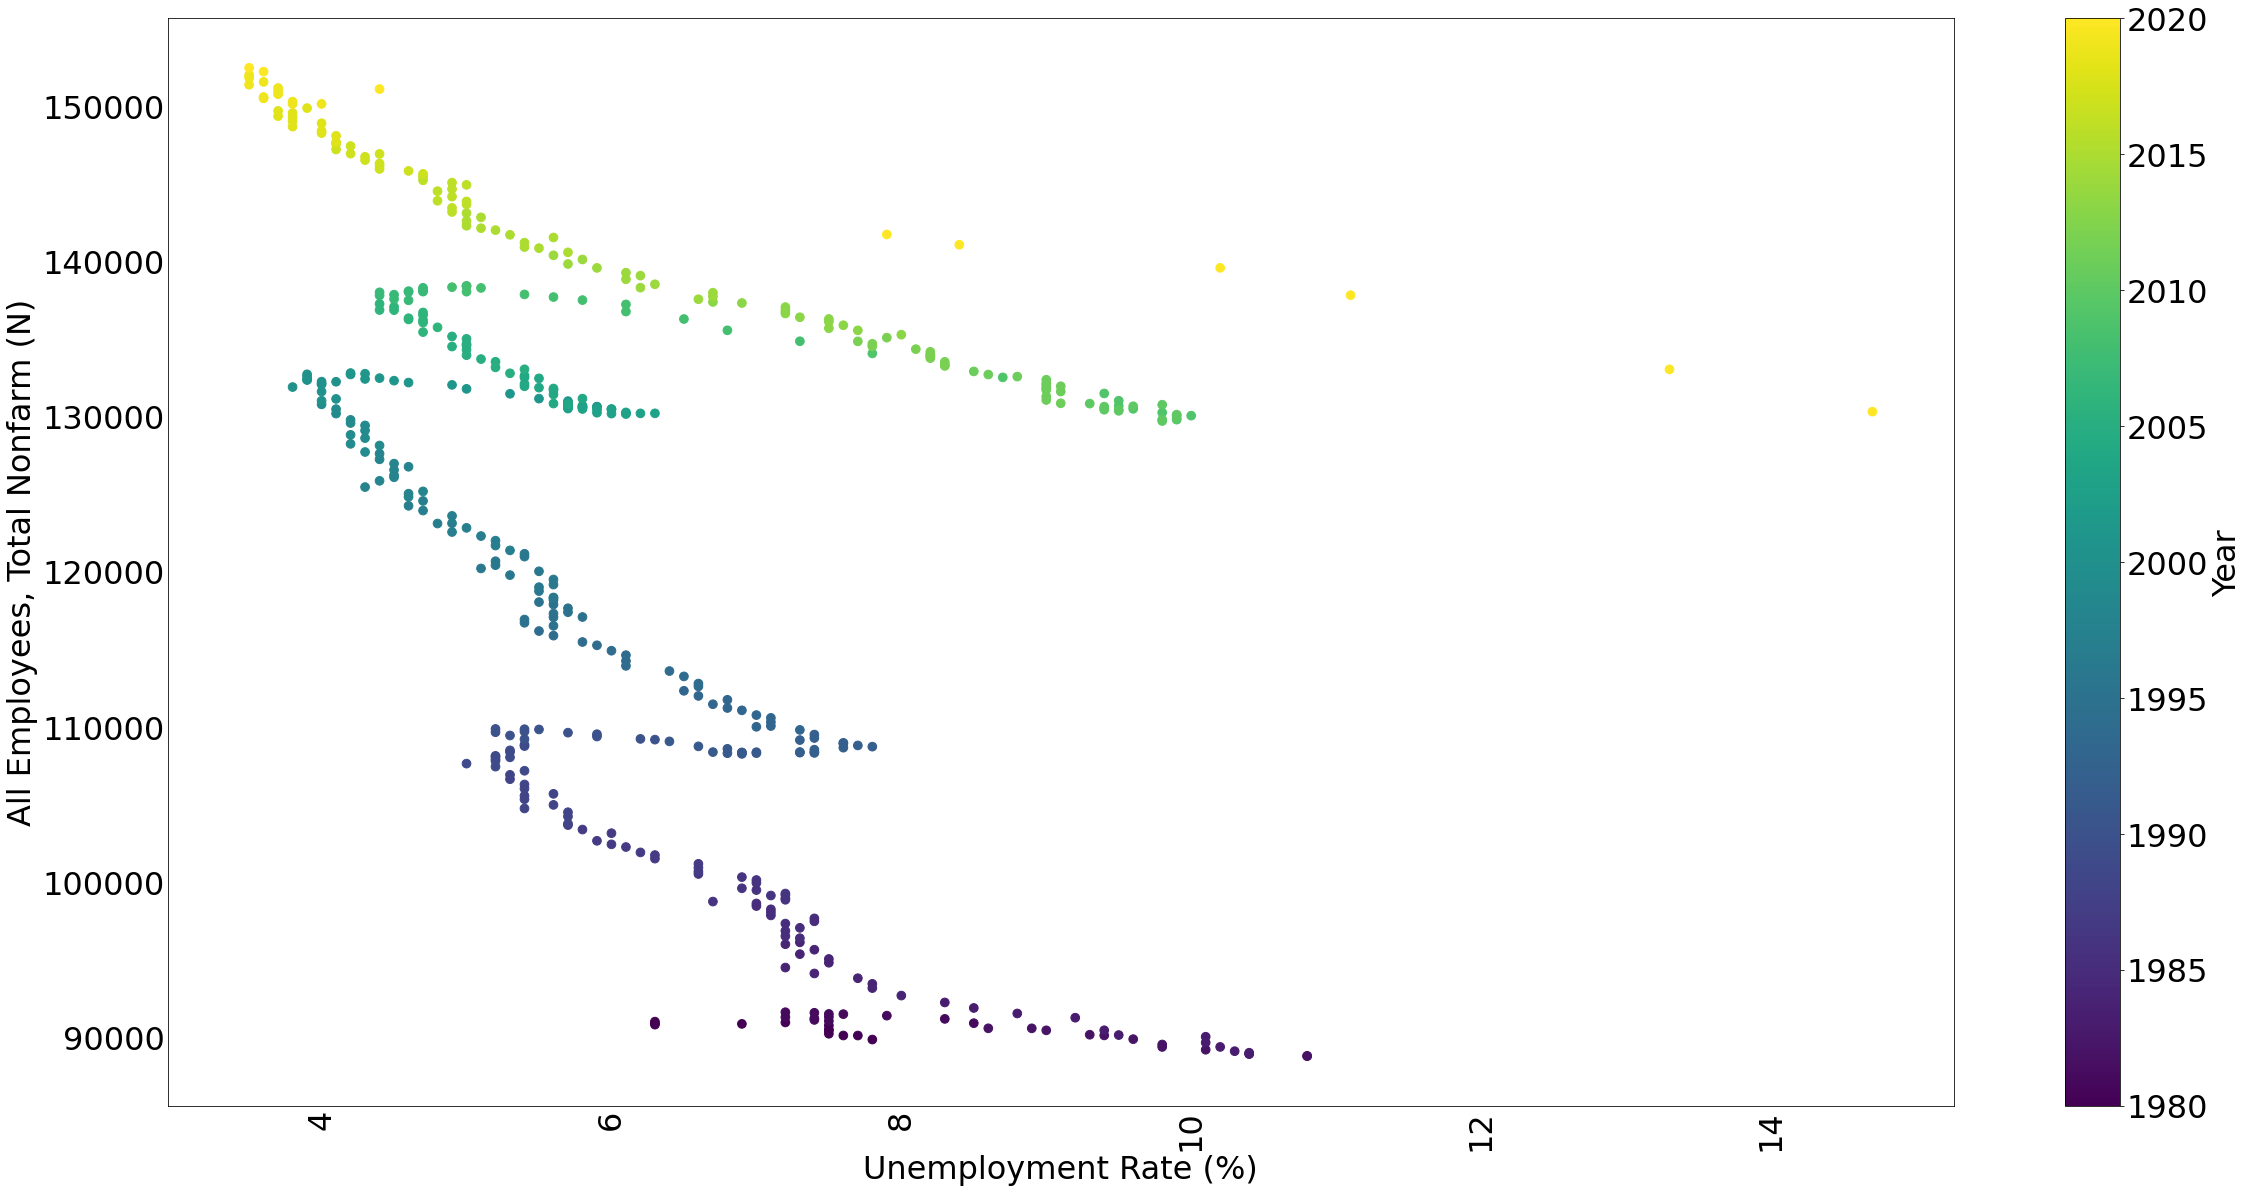

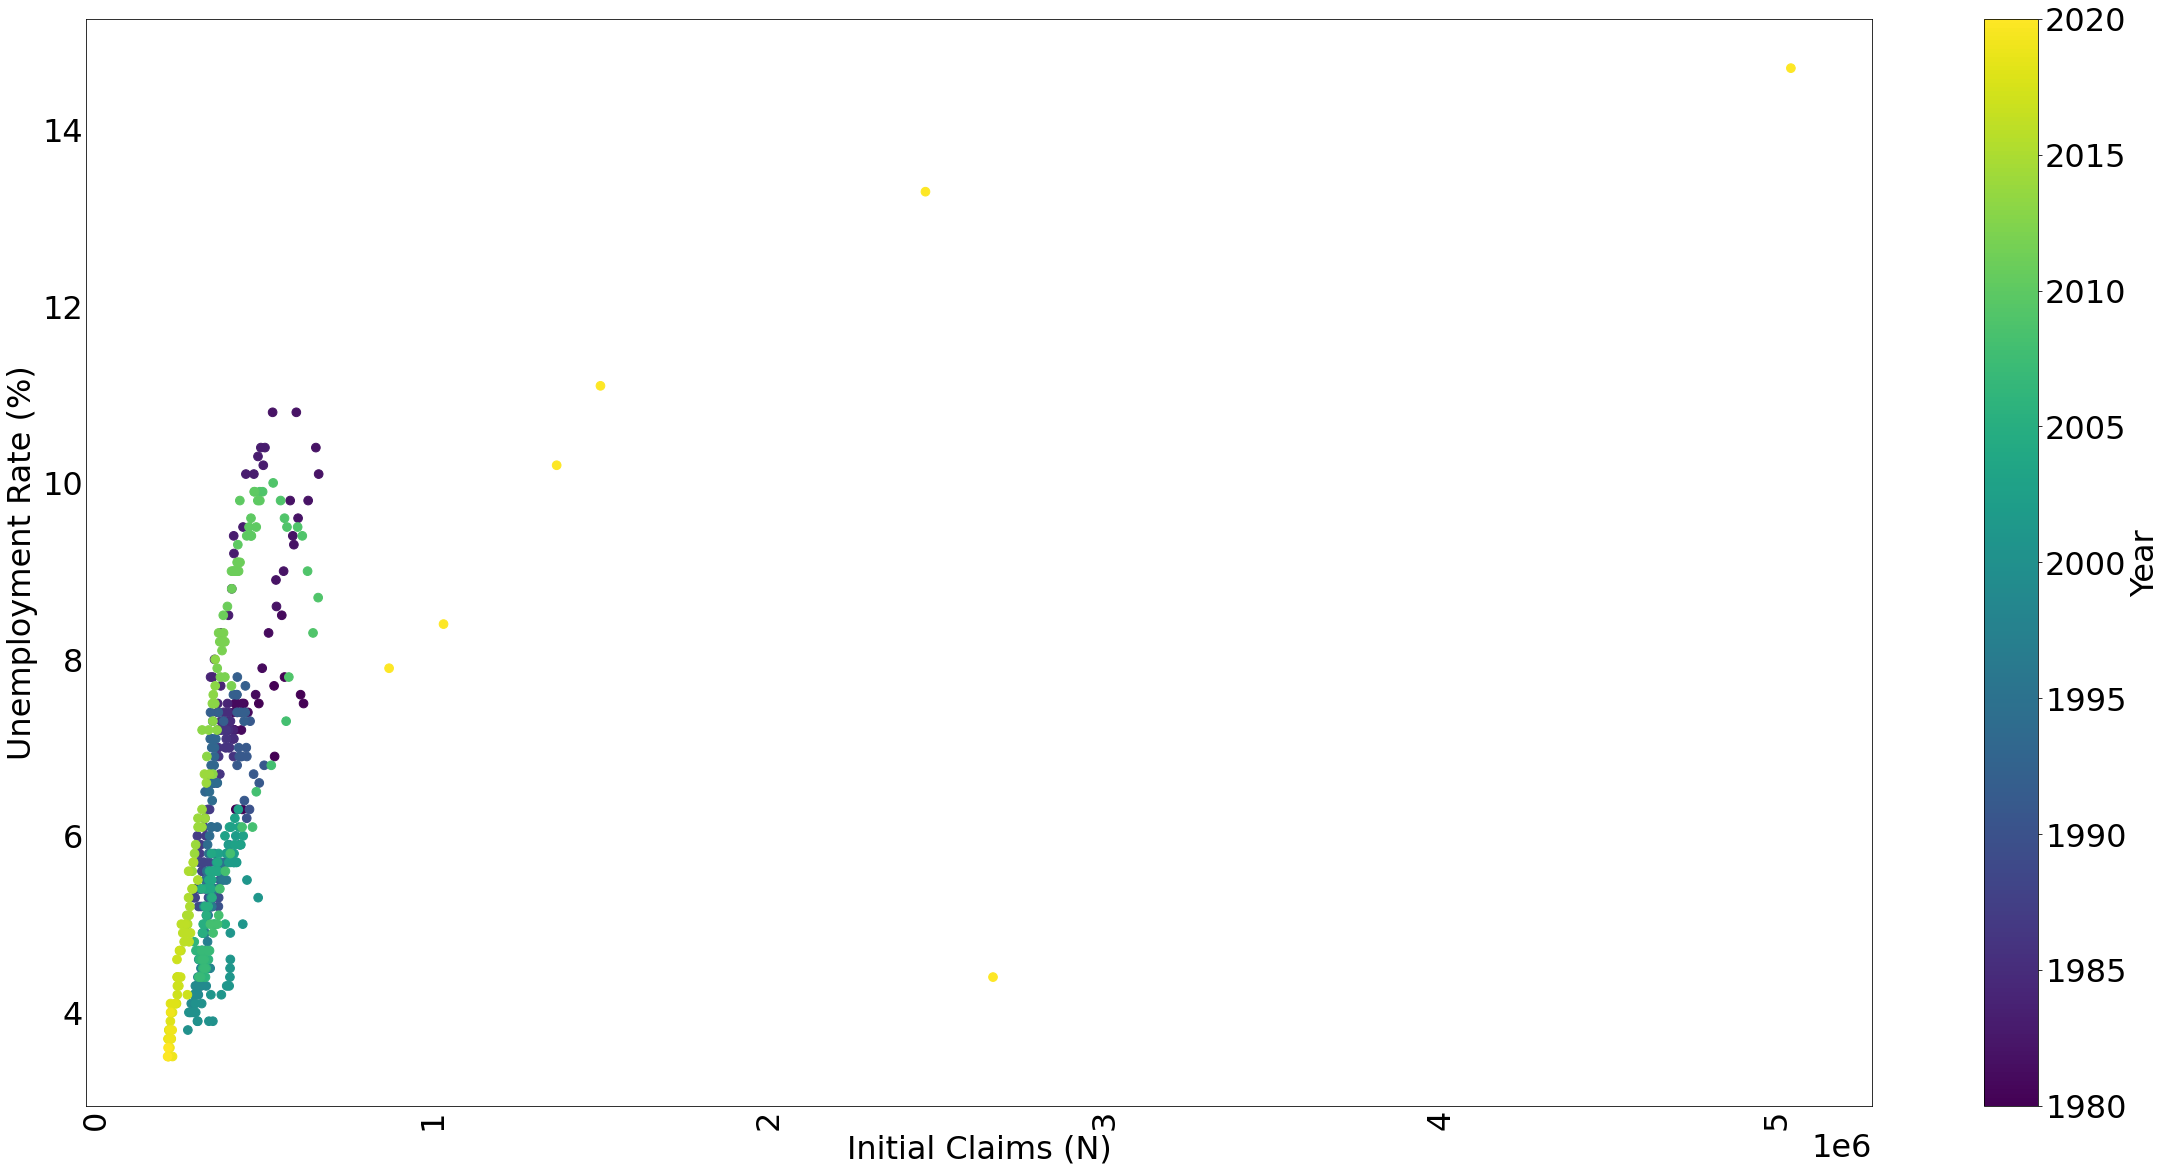

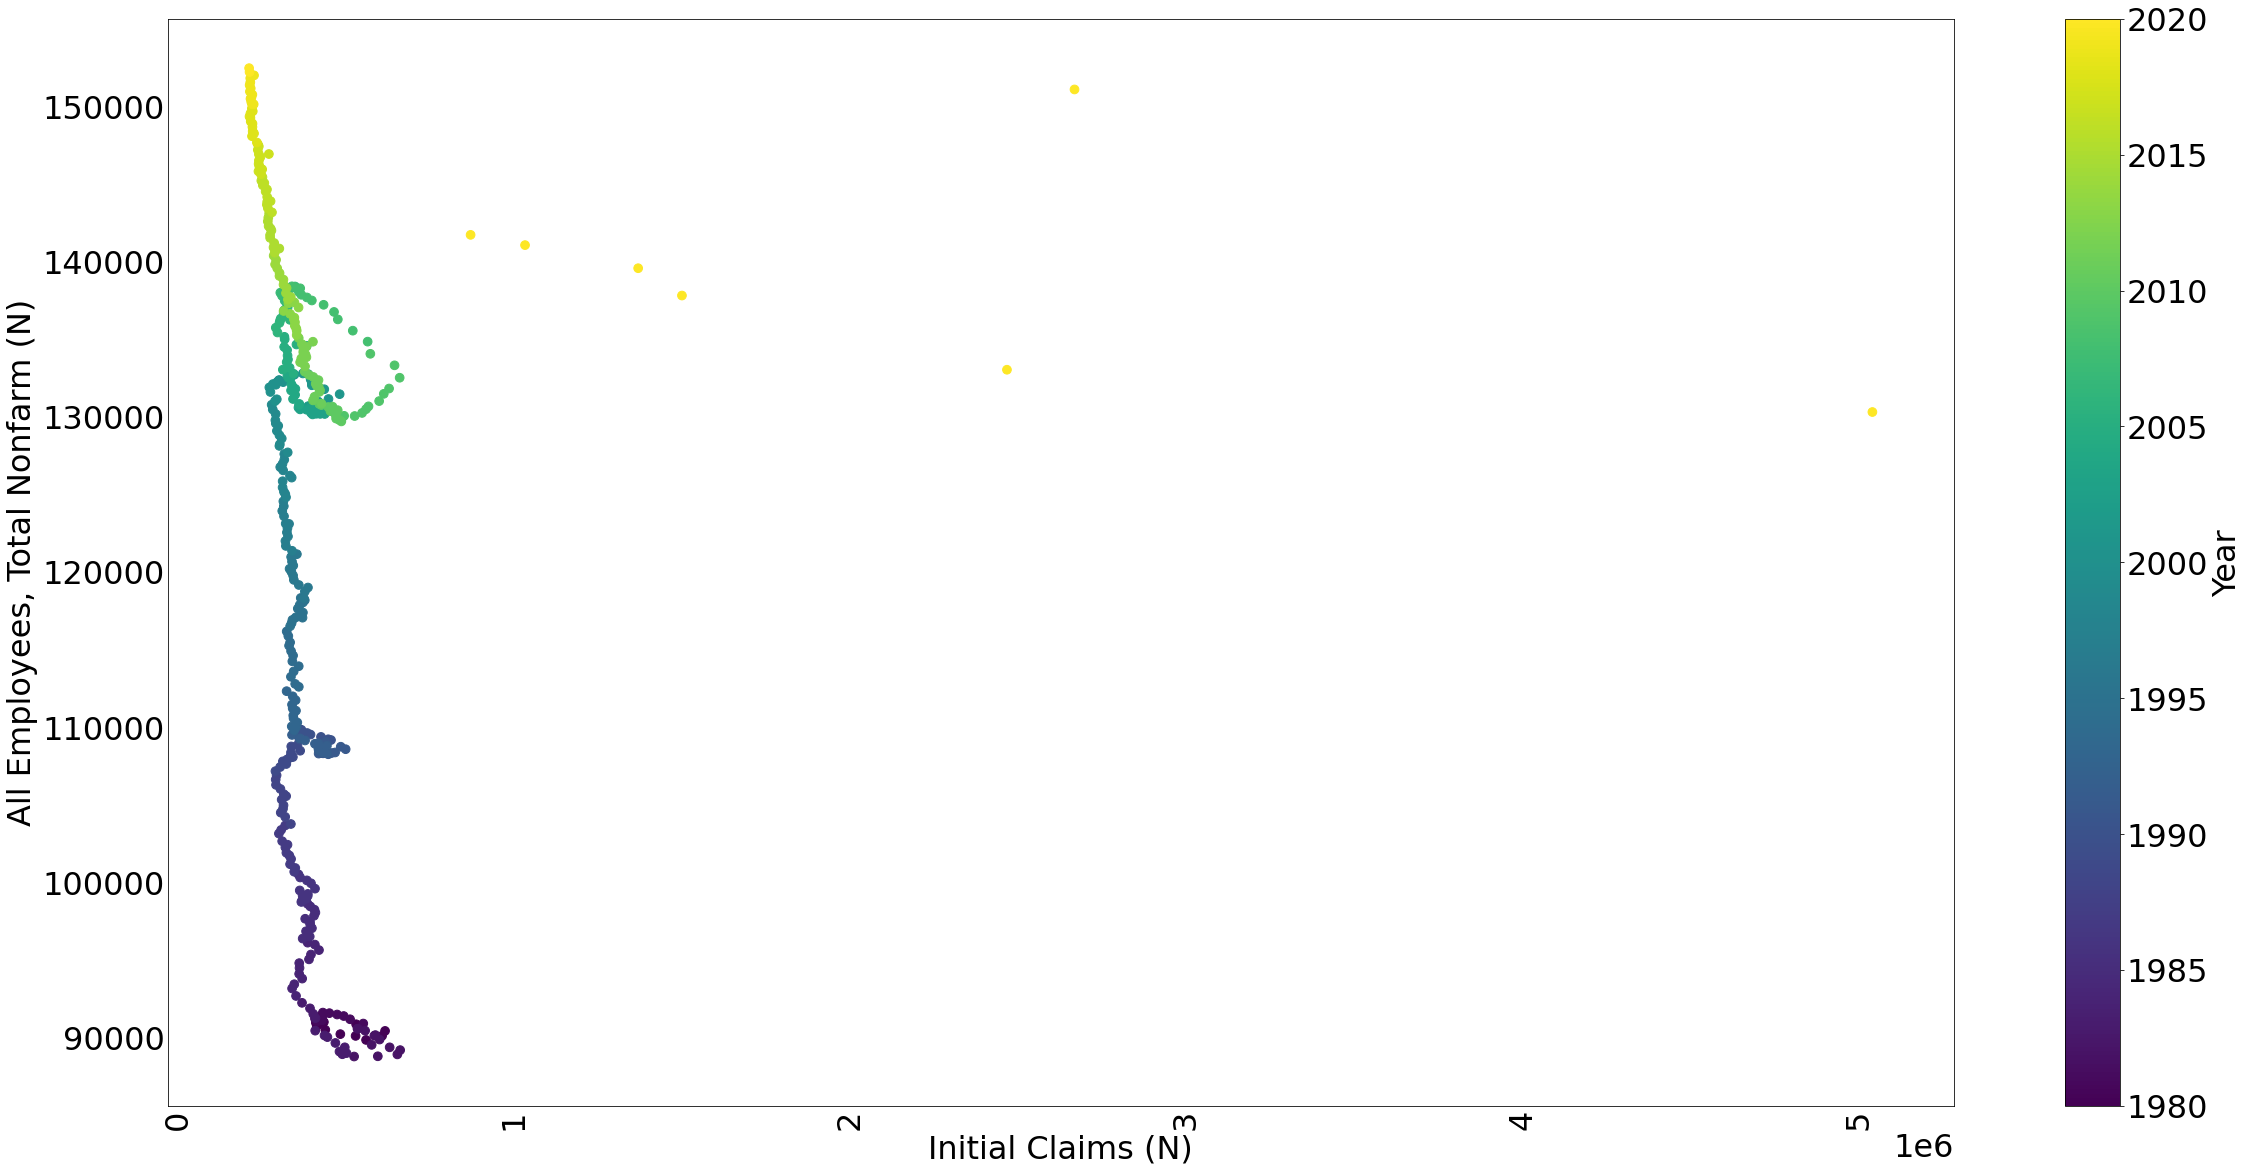

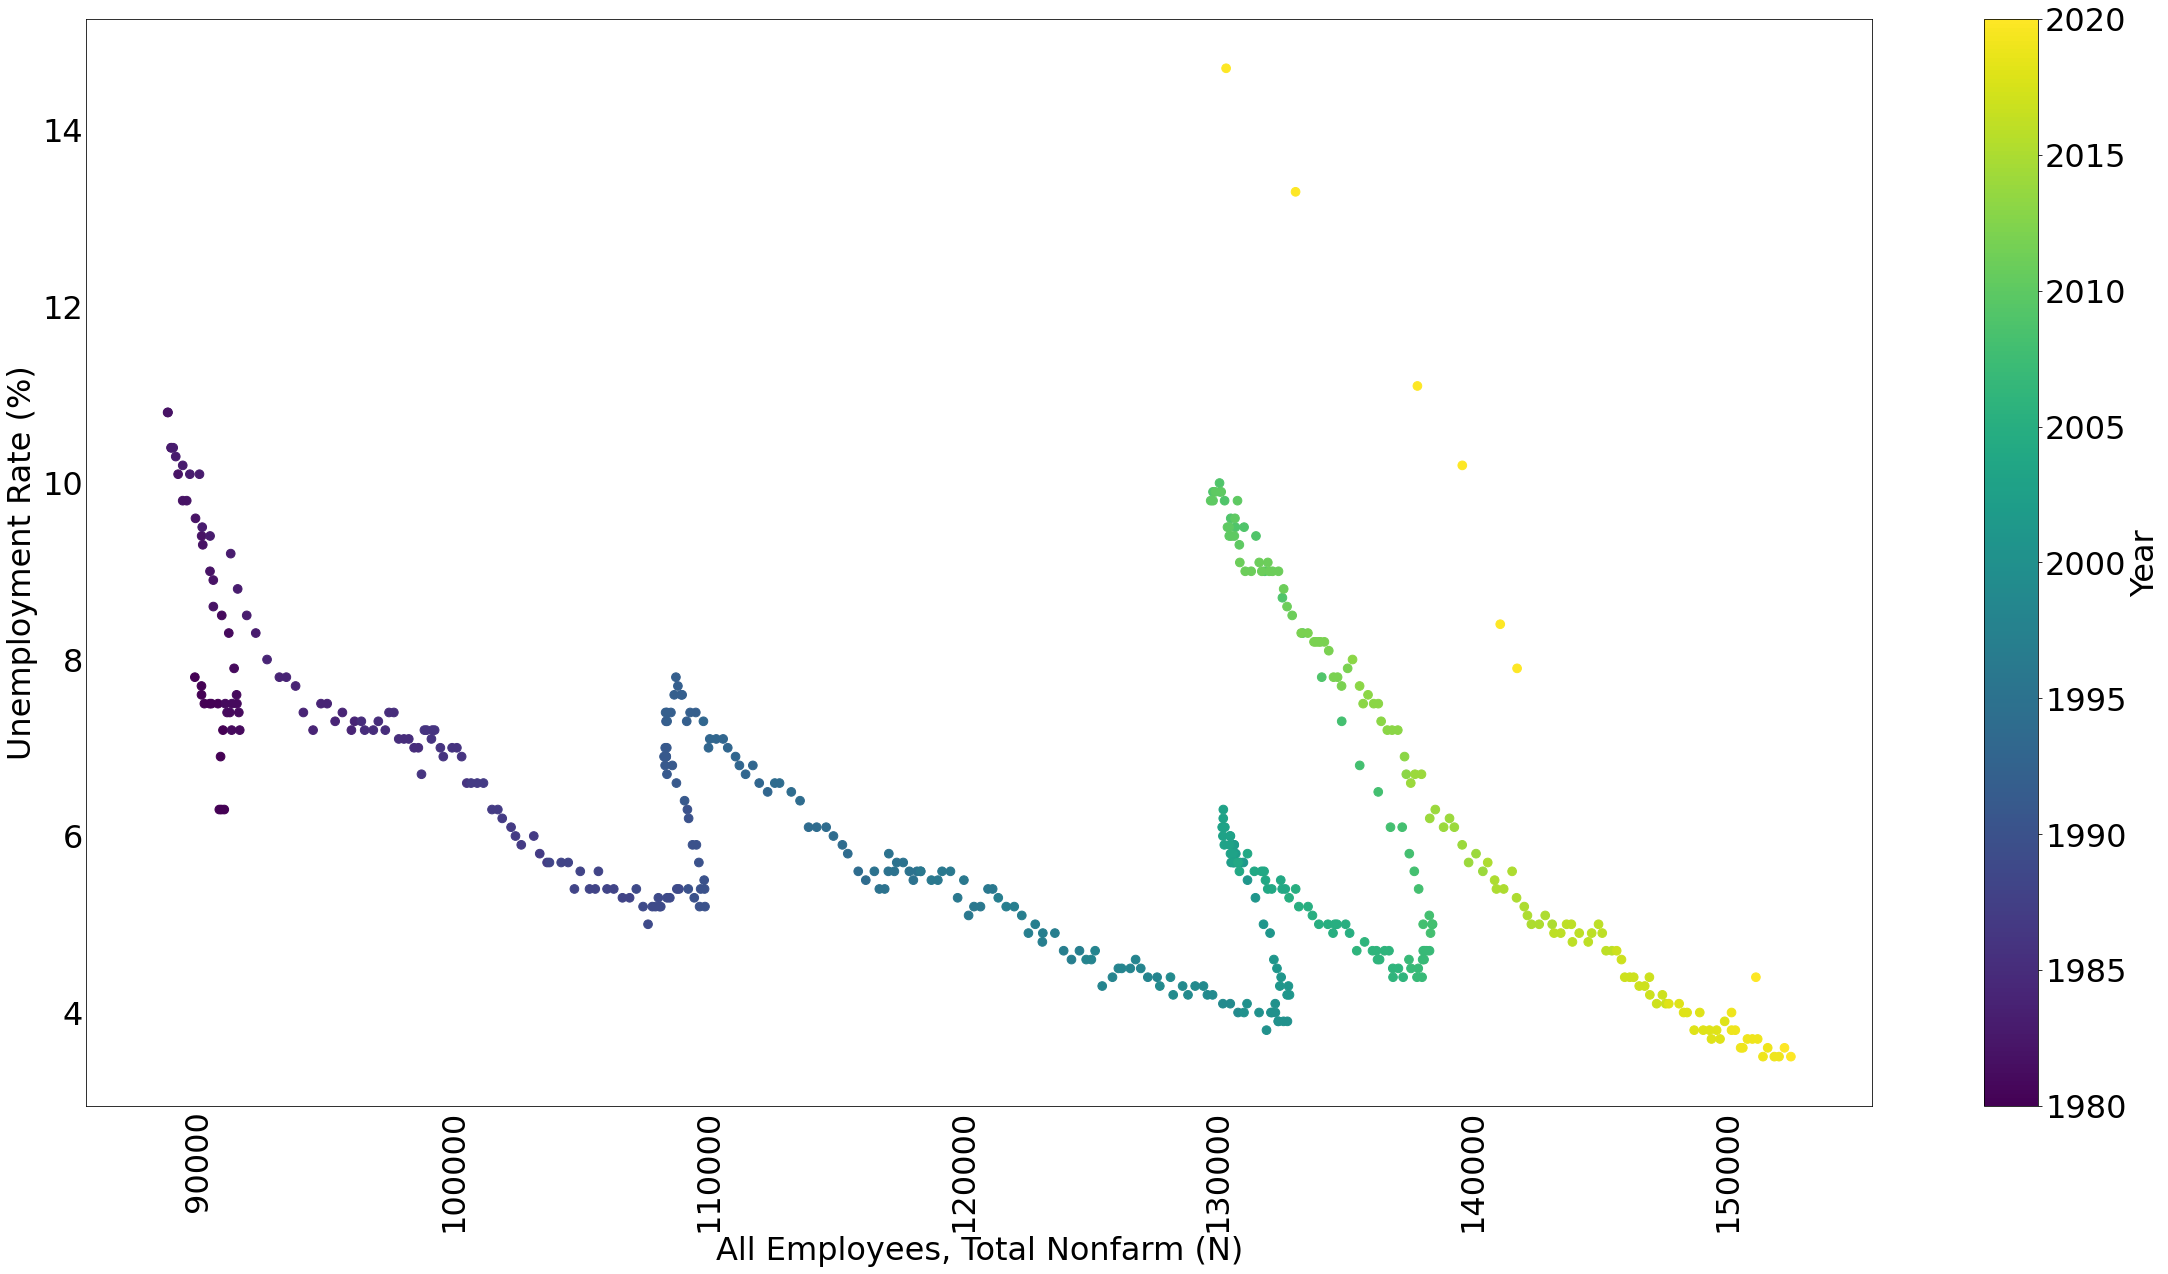

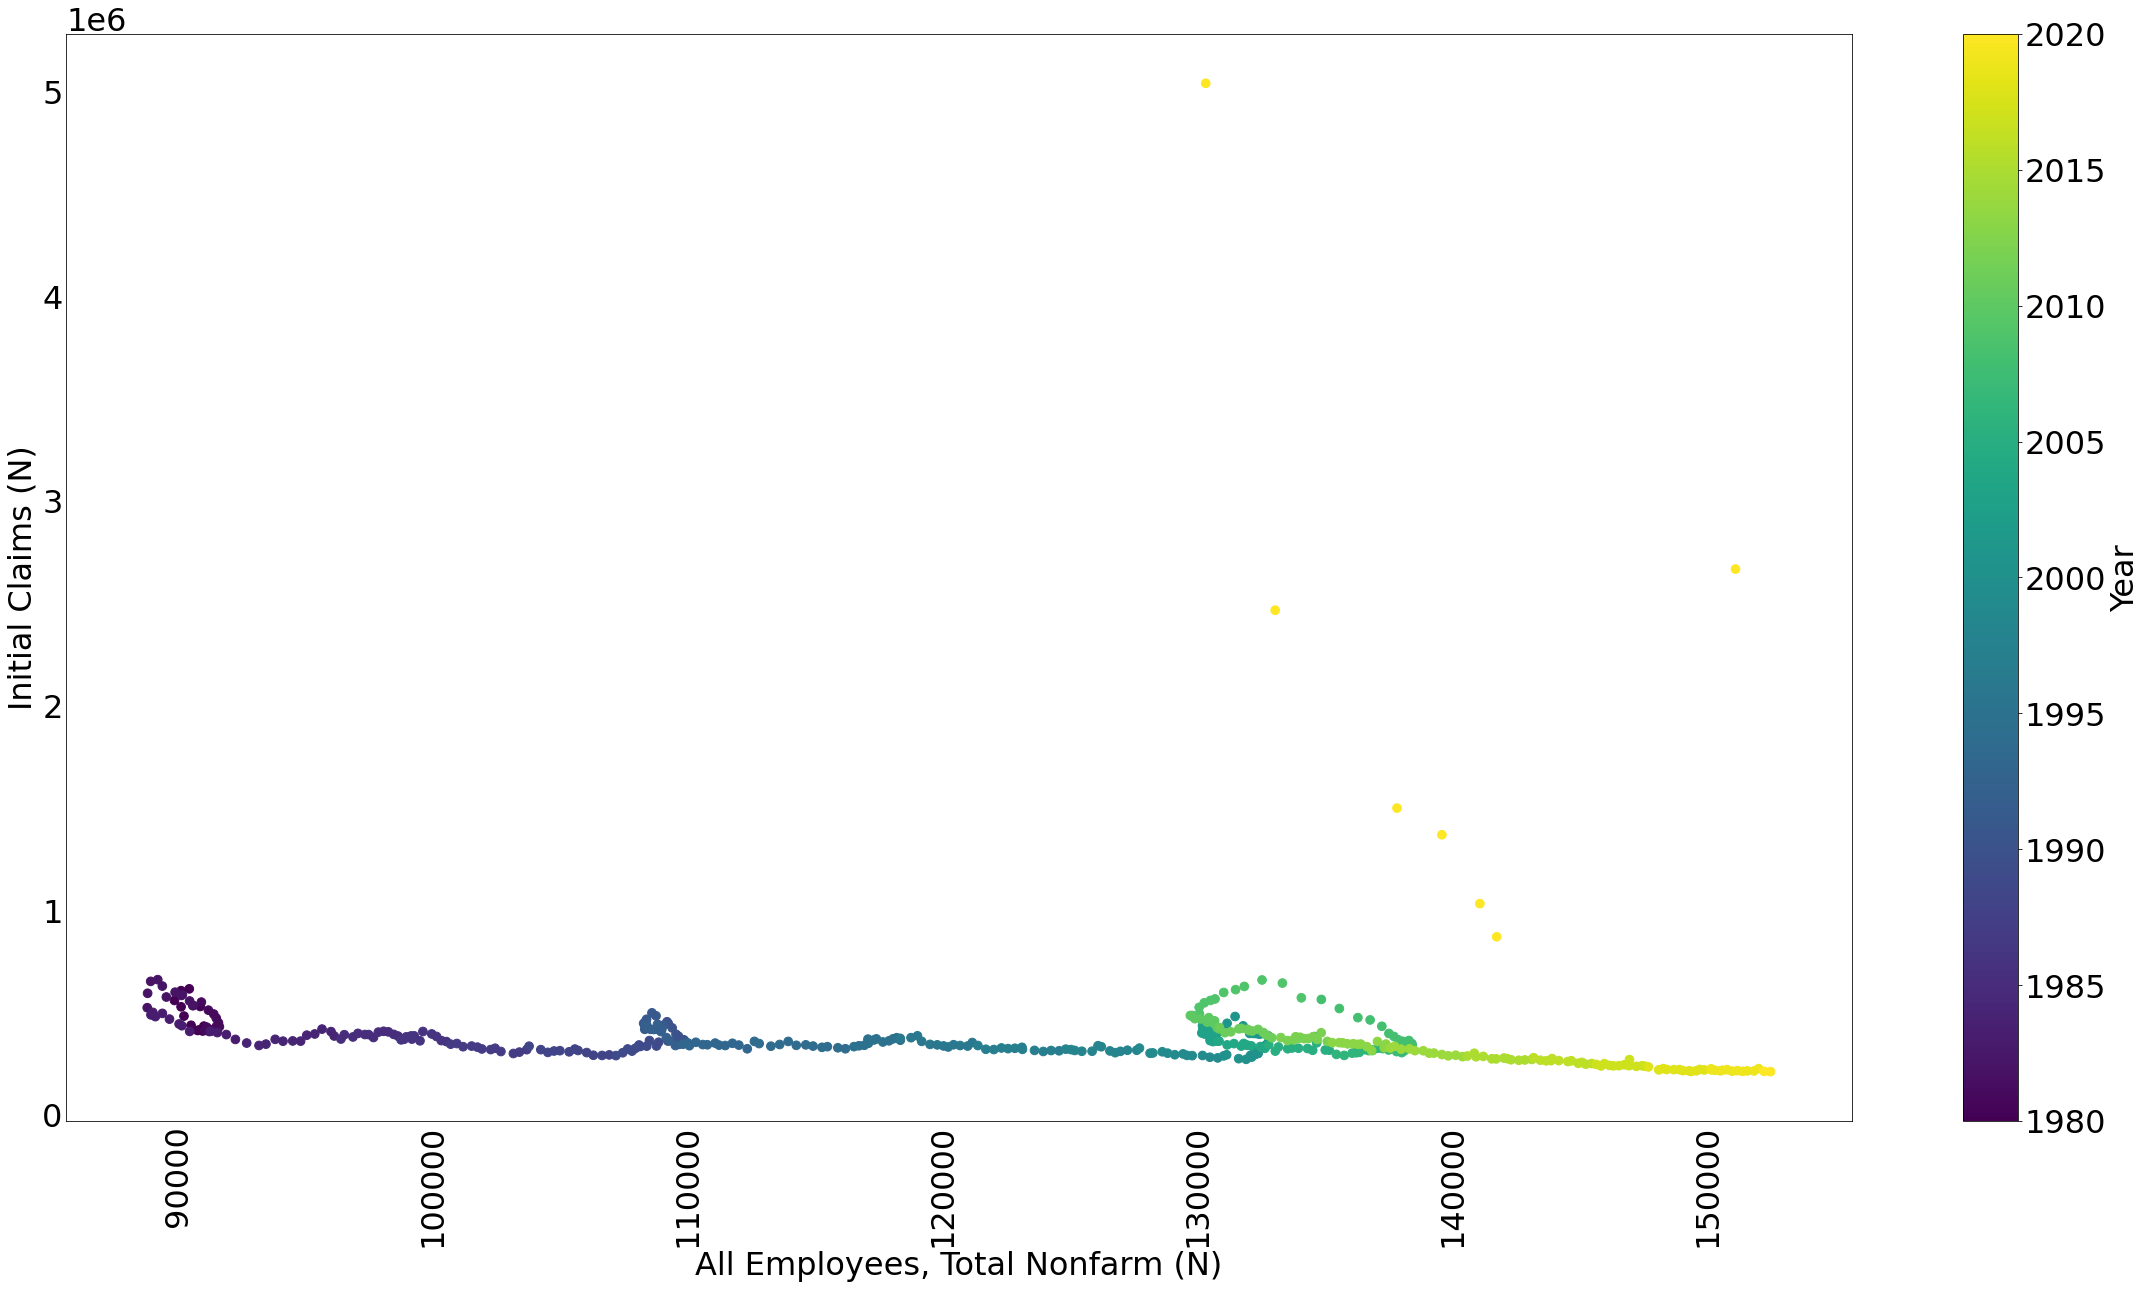

In [6]:
# Creating a scatter graph

plt.rcParams.update({"font.size":32})
plot_ts_scatter(data)

### Question #2 

Creating a correlation Matrix

In [56]:
import pandas as pd
from datlib.plots import * 
from datlib.FRED import *
import seaborn as sn
import matplotlib.pyplot as plt

data_Matrix = {"Nominal GDP": ["GDP"],
        "Real GDP": ["GNP"],
        "Consumer Price Index": ["CPIAUCSL"]}

start = datetime.datetime(1980, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "M")

start = datetime.datetime(1980, 1, 1)
end = datetime.datetime.today()
data = gather_data(data_codes = data_codes, 
                   start = start,
                  end = end,
                  freq = "M")

df = pd.DataFrame(data_Matrix,columns=['Nominal GDP','Real GDP','Consumer Price Index'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

TypeError: unhashable type: 'list'

In [58]:
from datlib.plots import * 
from datlib.FRED import *
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {"Nominal GDP": "GDP",
              "Real GDP": "GNP",
              "Consumer Price Index": "CPIAUCSL"}

df = pd.DataFrame(data,columns=['Nominal GDP','Real GDP','Consumer Price Index'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

ValueError: If using all scalar values, you must pass an index

AttributeError: 'dict' object has no attribute 'plot'

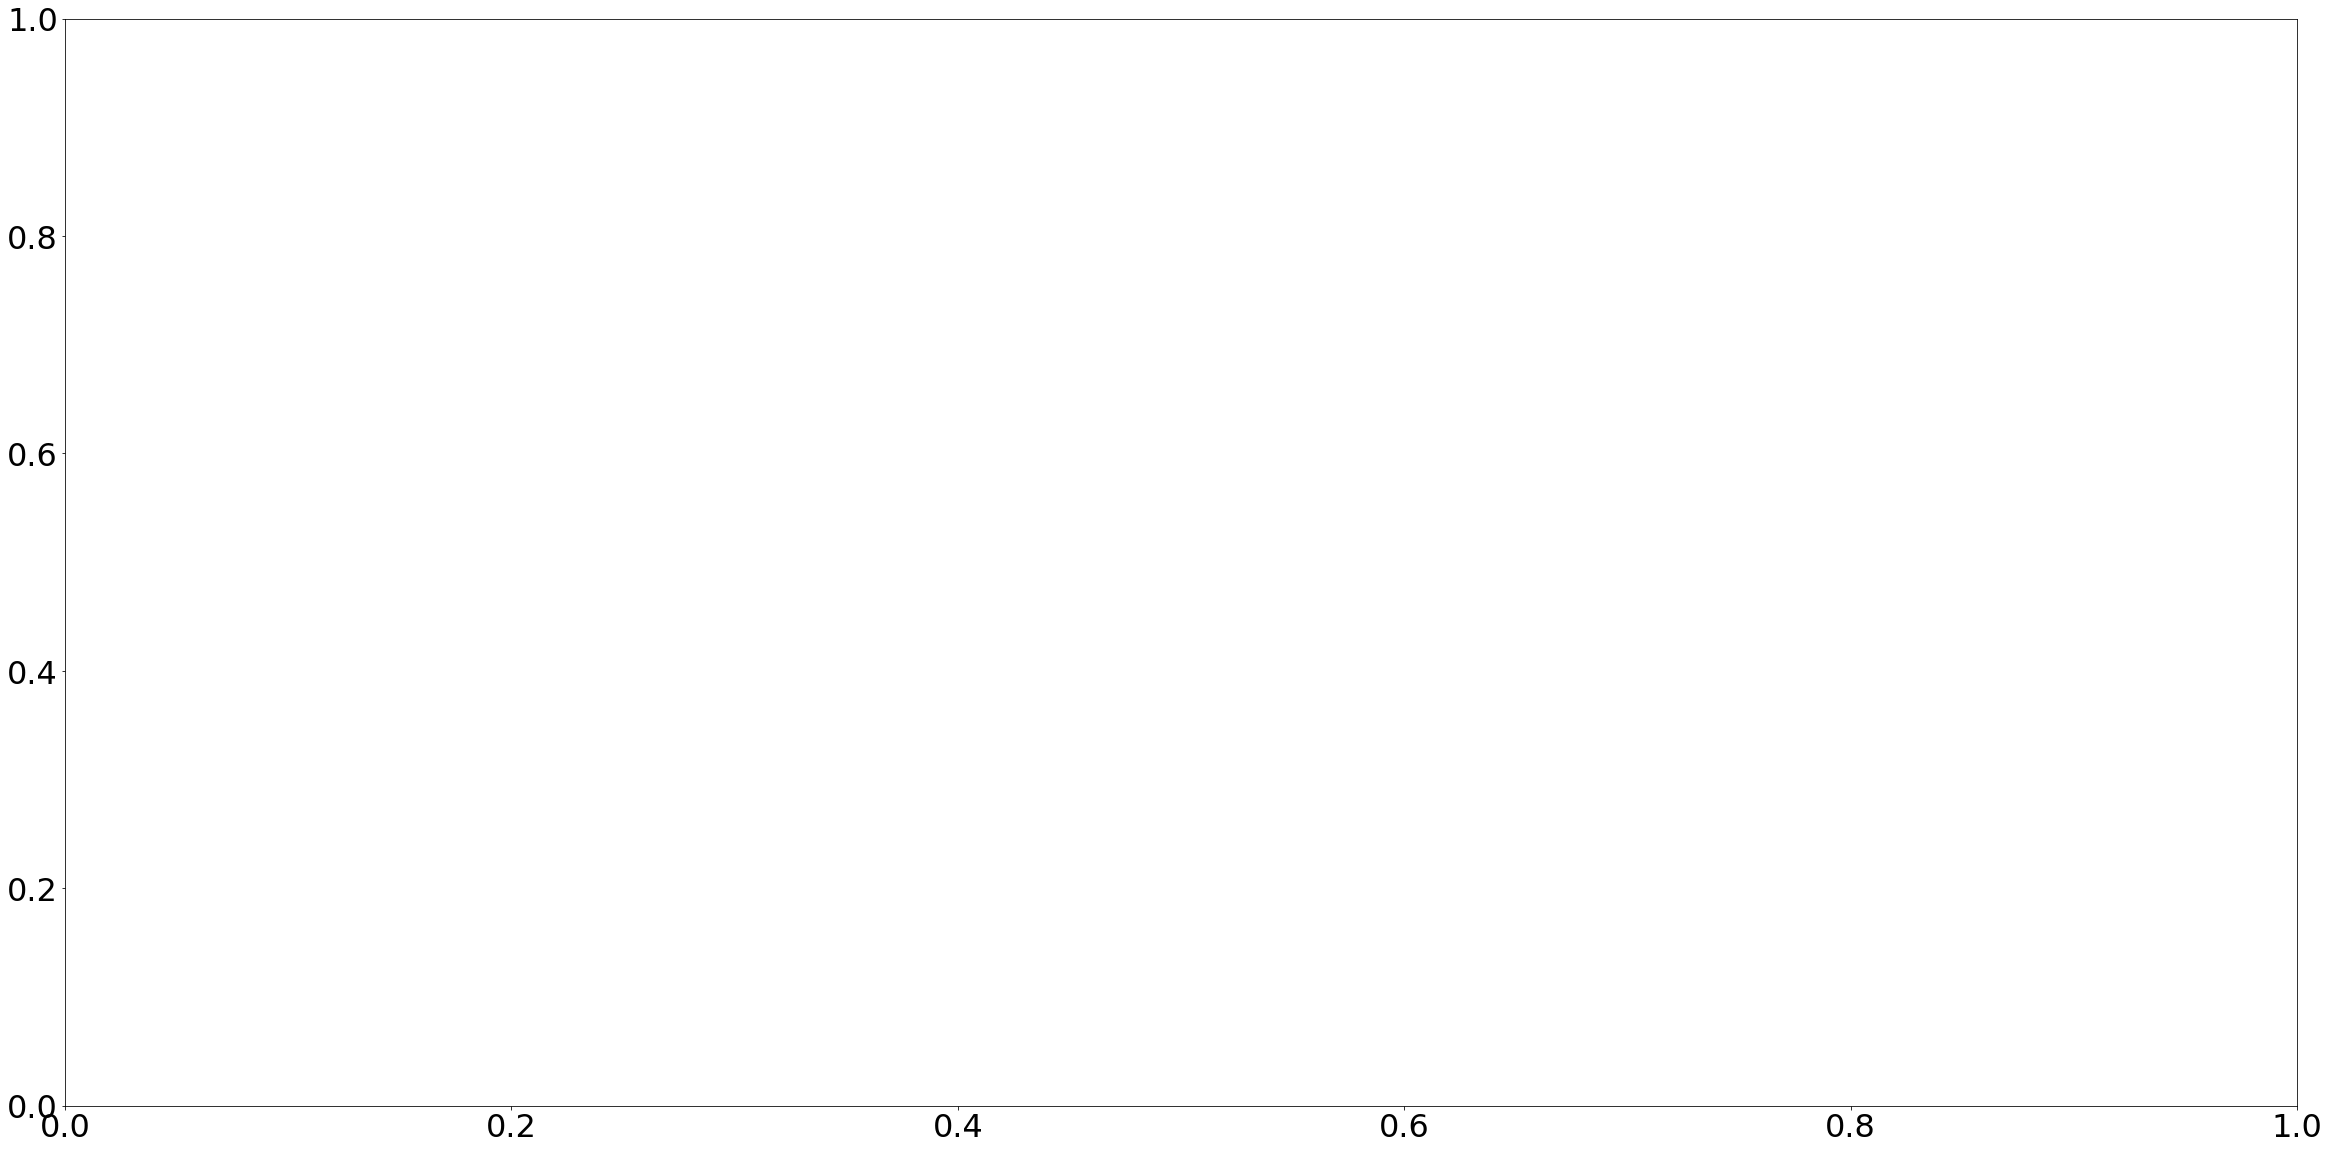

In [59]:
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.ymargin'] = 0

plot_lines(df = data, linewidth = 1.5, figsize = (40, 20), pp = None, show_inversion = True)

In [60]:
plot_ts_scatter(data[["1 M (%)", "30 Y - 1 M"]], s = 75, figsize = (40, 20))

TypeError: unhashable type: 'list'

In [61]:
plot_lines(df = data[["Expected Inflation (%)","Inflation (%)"]].dropna(), title = None, h_line = 2,
           legend = True, linewidth = 1.5, figsize = (40, 20), pp = None)

TypeError: unhashable type: 'list'

In [ ]:
plot_lines(df = data[["1 M (%)", "30 Y (%)", "30 Y - 1 M"]], title = "Yields", linewidth = 1.5, figsize = (40, 20), pp = None)

In [ ]:
T_data = data.T
T_data.rename(columns={name : str(name)[:10] for name in T_data.keys()}, inplace = True)
keys = list(T_data.keys())
T_data_trunc = T_data[keys[-181::60]]
max_y = T_data.max().max()
#for key, val in T_data_trunc.items():
plot_lines(df = T_data_trunc, title = "Yield Curve", linewidth = 1.5, figsize = (40, 20), full_index = True, pp = None)

In [ ]:
from matplotlib.animation import FuncAnimation
import math         
def plot_curves(date, *kwargs):
    #ax.clear()
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])
 
    # the FuncAnimation cycles from 0 to i frames,
    plot_df = df[date]
    alpha = 1 if date in write_dates else .1
    color = "C" + str(math.ceil(int(date[5:7])/3)) if date != write_dates[0] else "k"

    # If no secondary_y (axis), plot all variables at once

    plot_df.plot.line(linewidth = linewidth, ax = ax, alpha = alpha, color = color)
    if date in write_dates: 
        plt.text(len(plot_df.keys()) - 1, plot_df["30 Y (%)"], date[5:], color = color)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(str(date)[:10] + "\n" + "Yield Curve (U.S. Treasuries)", fontsize = 30)
    print(date)
    
def init(*kwargs):
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    plt.xticks([i for i in range(len(data.index))], list(data.index))
    ax.tick_params(axis='x', rotation=90)
    # transform y-axis values from sci notation to integers
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])

dates = list(T_data.keys())[-166:]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0).drop("Expected Inflation (T10YIE)", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2020CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()

In [ ]:
dates = list(T_data.keys())[:200]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0).drop("Expected Inflation (T10YIE)", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2008CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()